In [37]:
import numpy as np
import numpy.random as npr
import gym
from gym import spaces
from gym.utils import seeding
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import itertools
from typing import List

class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

In [38]:
def BrownianGenerate(T, N):
    dt = T/N
    X = np.zeros(N)
    X[1:N+1] = np.sqrt(dt) * npr.normal(size=N-1)
    B = np.cumsum(X)
    return B

def spread_cost(dn, tick_size):
    return dn * tick_size

def impact_cost(dn, tick_size, lot_size):
    return dn ** 2 * tick_size / lot_size

In [39]:
n = 5000
h = 5
pe = 50
sig = 0.1

# trading params
tick_size = 0.1
lot_size = 100
n_action = 5
M = 10

# calculated params
dt = 1 / n
lmbda = np.log(2) / h
action_space = lot_size * np.arange(-n_action, n_action+1)
holdings = np.arange(-M, M+1)


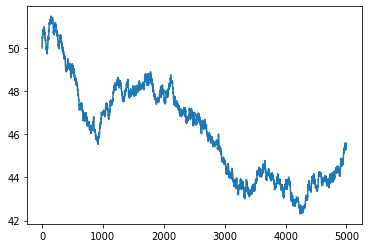

In [40]:
npr.seed(0)
# 1. Eucler method
xt = np.zeros(n, dtype=np.float64)
for i in range(1, n):
    xt[i] = xt[i-1] - lmbda * xt[i-1] * dt + sig * np.sqrt(dt) * npr.normal()
price = np.exp(xt) * pe
plt.plot(price)

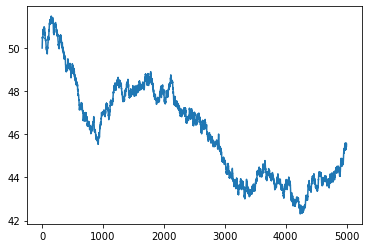

In [110]:
npr.seed(0)
# 2. Solution in terms of integral
t = np.arange(0, 1, dt)
w = np.zeros(n)
x0 = 0

# calculate integral
for i in range(1, n):
    w[i] = w[i-1] + np.sqrt(dt) * np.exp(lmbda * t[i-1]) * npr.normal()

# intergral solution
ex = np.exp(-lmbda * t)
x = x0*ex + sig*ex*w

# transform price
price = np.exp(x) * pe
plt.plot(price)

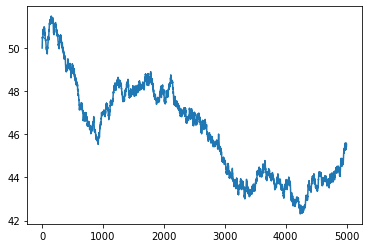

In [111]:
npr.seed(0)
# 2. Solution in terms of integral
t = np.arange(0, 1, dt)
w = np.zeros(n)
x0 = 0

ex = np.exp(-lmbda * t)
w = np.sqrt(np.diff(np.exp(2*lmbda*t) - 1)) * npr.normal(size=n-1)
w = np.insert(w, 0, 0)
x = x0*ex + 0*(1-ex) + sig*ex*np.cumsum(w) / np.sqrt(2*lmbda)

# transform price
price = np.exp(x) * pe
plt.plot(price)

In [22]:
def moving_average(iterable, n=3):
    # moving_average([40, 30, 50, 46, 39, 44]) --> 40.0 42.0 45.0 43.0
    # http://en.wikipedia.org/wiki/Moving_average
    it = iter(iterable)
    d = deque(itertools.islice(it, n-1))
    print(next(it))
    d.appendleft(0)
    s = sum(d)
    print(d)
    print(s)
    for elem in it:
        s += elem - d.popleft()
        d.append(elem)
        yield s / n

In [35]:
prices = iter([1,2,3,4,5])
d = deque(itertools.islice(prices, 3), maxlen=5)
# print(prices)
for p in prices:
    print(p)
print(d)

4
5
deque([1, 2, 3], maxlen=5)


In [43]:
df = pd.DataFrame()
feature = pd.DataFrame()
df['APPL'] = feature['close']

In [46]:
df['close'].loc[:5].to_numpy()

array([50.        , 50.12489306, 50.15326369, 50.22272685, 50.38213403,
       50.5153648 ])

In [ ]:
class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(
        self,
        df: pd.DataFrame,
        window_size: int = 1,
        n_action: int = 5,
        max_asset: int = 5,
    ):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.prices = self.df['close']
        self.window_size = window_size
        self.window = deque(maxlen=self.window_size)
        self.shape = (window_size, self.df.shape[1])

        # spaces
        self.action_space = spaces.MultiDiscrete(np.ones(max_asset) * (n_action - 1))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)

        # episode
        self._start_tick = self.window_size
        self._end_tick = self.df.shape[0] - 1
        self._current_tick = None
        self._last_trade_tick = None
        self._first_rendering = None
        self.done = None
        self.position = None
        self.position_history = None
        self.total_reward = None
        self.total_profit = None
        self.history = None
    
    # @property
    # def start_idx(self):
    #     return max(self.current_tick - self.window_size + 1, self.start_tick)
    
    # @property
    # def end_idx(self):
    #     return min(self._current_tick + 1, self.end_tick)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.done = False
        self.current_tick = self.start_tick
        self.last_trade_tick = self.current_tick - 1
        self.position = Positions.Short
        self.total_reward = 0.
        self.total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {
            'position_history': (self.window_size * [None]) + [self.position]
        }
        return self._get_observation()


    def step(self, action: List[int]):
        self.done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self.done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        # process window
        self.window.append(df['close'].loc[:self.start_tick].to_numpy())
        return self.window


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self.history['position_history'][self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self.history['position_history']))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self.history['position_history'][i] == Positions.Short:
                short_ticks.append(tick)
            elif self.history['position_history'][i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError
